In [1]:
# Autor: Elvis do A. Soares
# Github: @elvissoares
from sys import stdout

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
%matplotlib inline

# Dinâmica Molecular usando OpenMM

https://openmm.org/

## Instalando o OpenMM

Instalação em CPU

In [2]:
# !conda install -c conda-forge openmm
# pip install openmm

Instalação em GPU

In [3]:
# !conda install -c conda-forge openmm cuda-version=12 # para usar GPU
# pip install openmm[cuda12] # para usar com GPU

## Importando a Biblioteca

In [4]:
import mdtraj
import nglview

from openmm.app import *
from openmm import *
from openmm.unit import *

## Input com posição das partículas

In [5]:
xyz_data = pd.read_csv('../data/positions-N=864-rho=0.840-kT=0.710.xyz',sep='\t',skiprows=2,names=['x','y','z'])

In [6]:
xyz_data

,x,y,z
0,9.50185,9.41310,6.58248
1,1.60217,1.90719,7.76761
2,9.16342,1.03461,8.71883
3,0.75624,1.66058,9.44078
4,6.96636,9.71882,4.82582
...,...,...,...
859,8.42259,1.89441,1.32876
860,7.71757,8.58243,8.21504
861,8.86400,8.68088,1.87669
862,0.66307,6.66686,4.02066


Criando array com posições

In [7]:
initial_positions = xyz_data[['x','y','z']].values / 11.0

Número total de partículas

In [8]:
N_atoms = initial_positions.shape[0]

Posição da partícula 0

In [9]:
initial_positions[0]

array([0.86380455, 0.85573636, 0.59840727])

Gráfico das posições em $x$ e $y$

Text(0, 0.5, 'y')

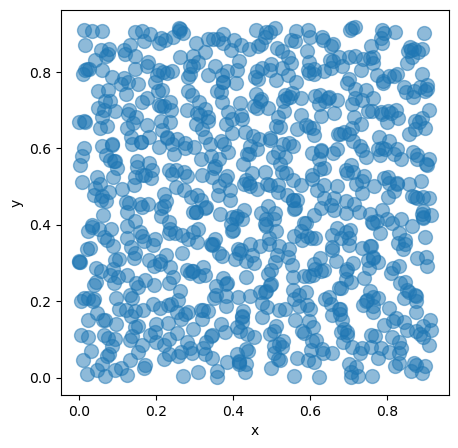

In [10]:
plt.figure(figsize=(5,5))
plt.plot(initial_positions[:,0],initial_positions[:,1],'o',ms=10.0,alpha=0.5)

plt.xlabel('x')
plt.ylabel('y')

## Simulação NVE no OpenMM

Variáveis das partículas de LJ (no caso Argônio)

In [11]:
# Parâmetros físicos do argônio
epsilon = 117.8 * kelvin * BOLTZMANN_CONSTANT_kB * AVOGADRO_CONSTANT_NA
sigma = 3.419 * angstrom
mass = 39.948 * amu

# Parâmetros da simulação 
cutoff = 2.5*sigma

print(epsilon)

979.4436964184517 J/mol


Condição termodinâmica

In [12]:
rho = 0.84/sigma**3

print(rho)

0.021017544890034698 /(A**3)


Tamanho da caixa

In [13]:
L = (N_atoms/rho)**(1/3)

print(L)

34.512566219789825 A


`system`: número de partículas e suas massas, vetores da célula (caixa de simulação)

In [14]:
system = System()
for i in range(N_atoms):
    system.addParticle(mass)

In [15]:
box_matrix = L * np.identity(3)
system.setDefaultPeriodicBoxVectors(*box_matrix)

Qual o número de partículas?

In [16]:
system.getNumParticles()

864

`topology`: identifica os átomos e informações relacionadas: ligações química, resíduos e cadeias.

Todos os átomos de argônio são agrupados em um resíduo e uma cadeia. Essa informação é necessária para escrever arquivos PDB.

In [17]:
# Define a relatively boring topology object.
topology = Topology()
topology.setPeriodicBoxVectors(box_matrix)
chain = topology.addChain()
residue = topology.addResidue("argon", chain)
element_Ar = Element.getByAtomicNumber(18)
for _iatom in range(N_atoms):
    topology.addAtom("Ar", element_Ar, residue)

`force`: define qual o topo de interação modificará as velocidades e as posições das partículas

- existem campos de força já definidos ou usuário pode criar
- adiciona essa info ao sistema

In [18]:
energy = '4*epsilon*((sigma/r)^12-(sigma/r)^6); sigma=(sigma1+sigma2)/2; epsilon=sqrt(epsilon1*epsilon2)'
force = CustomNonbondedForce(energy)
force.addPerParticleParameter('sigma')
force.addPerParticleParameter('epsilon')
for i in range(N_atoms):
    force.addParticle([sigma,epsilon])
force.setCutoffDistance(cutoff)
force.setNonbondedMethod(force.CutoffPeriodic)
force_index = system.addForce(force)

`integrator`: define o integrador a ser utilizado (Verlet para NVE)

In [19]:
dt = 3 * femtoseconds # (10^-15 s)
integrator = VerletIntegrator(dt)

`platform`: define qual plataforma usar (CPU, CUDA)

In [20]:
platform = Platform.getPlatformByName('CPU')

`simulation`: une a topologia, sistema, integrador e a plataforma. Contem todas as informações do estado do sistema: posições, velocidades, outros parametros

In [21]:
# Define um objeto de simulação
simulation = Simulation(topology, system, integrator, platform,)

# Inicializa as posições iniciais
simulation.context.setPositions(initial_positions * L)

# Inicializa velocidades com valores aleatórios à temperatura de 300K.
simulation.context.setVelocitiesToTemperature(300 * kelvin)

`state`: uma fotografia do estado do sistema. Necessário para acessar as posições, energias e forças

In [22]:
state = simulation.context.getState(getEnergy=True, getForces=True)

Energia Potencial Inicial

In [23]:
state.getPotentialEnergy()

Quantity(value=-2000.886305809021, unit=kilojoule/mole)

Energia Cinética Inicial

In [24]:
state.getKineticEnergy()

Quantity(value=3346.668726016997, unit=kilojoule/mole)

Força sobre uma partícula

In [25]:
state.getForces()

Quantity(value=[Vec3(x=139.6071319580078, y=-12.410024642944336, z=114.98684692382812), Vec3(x=62.57542037963867, y=-149.14791870117188, z=-96.4740982055664), Vec3(x=242.79930114746094, y=-148.49436950683594, z=-72.68724822998047), Vec3(x=-116.47393798828125, y=47.13768768310547, z=8.701690673828125), Vec3(x=-6.237739086151123, y=303.06915283203125, z=59.40113830566406), Vec3(x=-86.83716583251953, y=-66.90798950195312, z=-344.69354248046875), Vec3(x=46.0157470703125, y=32.60715866088867, z=-58.463233947753906), Vec3(x=-185.5879669189453, y=36.24899673461914, z=-76.97750854492188), Vec3(x=70.94940948486328, y=-19.815757751464844, z=6.028088569641113), Vec3(x=231.91070556640625, y=-104.81619262695312, z=-62.33684158325195), Vec3(x=-436.27490234375, y=59.863182067871094, z=466.4000244140625), Vec3(x=229.06573486328125, y=233.40586853027344, z=73.55891418457031), Vec3(x=388.63641357421875, y=234.46356201171875, z=-19.679092407226562), Vec3(x=-100.15535736083984, y=236.26123046875, z=132.12

A célula seguinte define todos os reporters e realiza a simulação de MD

In [26]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve a geometria inicial com um arquivo PDB
positions = simulation.context.getState(getPositions=True).getPositions()
with open("ljinit.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

# Escreve cada frame em arquivo DCD de trajetórias a cada 1000 passos
simulation.reporters.append(DCDReporter("ljtraj.dcd", 1000))

# Escreve num arquivo csv a cada 100 passos 
simulation.reporters.append(
    StateDataReporter(
        "ljscalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True)
)

# Roda a simulação molecular com 40000 passos
simulation.step(40000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

#"Step","Temperature (K)"
1000,395.52042253925464
2000,388.3253953055266
3000,406.5753668002253
4000,395.2874701022771
5000,390.3454518875398
6000,407.7609045366255
7000,395.4456514226075
8000,405.07853784205264
9000,393.73236172749665
10000,392.0744529008199
11000,389.67313032765753
12000,396.6830838308583
13000,395.8940351616294
14000,400.1428476323668
15000,393.5507823613579
16000,391.6358966403807
17000,389.93455050719365
18000,390.93688753344526
19000,402.8108424093966
20000,399.3435103743212
21000,406.5800687544542
22000,384.41376024347113
23000,404.09754614180014
24000,400.77051626013923
25000,392.73852164643824
26000,405.2726842361724
27000,394.9343976670759
28000,408.0766762585522
29000,402.3781168212804
30000,392.91512874136606
31000,396.9907611712273
32000,398.59341307700555
33000,395.7821796215985
34000,384.18083264773935
35000,402.95446268181587
36000,392.1307303457461
37000,398.5573566775056
38000,409.9792867653795
39000,400.5443446310575
40000,398.0449641874001


### Análise dos dados

In [27]:
traj = mdtraj.load("ljtraj.dcd", top="ljinit.pdb")
view = nglview.show_mdtraj(traj)
view.add_unitcell()
view

NGLWidget(max_frame=39)

In [28]:
df = pd.read_csv("ljscalars.csv")

In [29]:
df.head()

,"#""Step""",Time (ps),Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K)
0,10,0.03,-2036.227620,1345.718337,313.853862
1,20,0.06,-2245.341225,1345.552269,333.244766
2,30,0.09,-2414.242679,1345.762418,348.938787
3,40,0.12,-2598.254312,1345.569391,365.997658
4,50,0.15,-2842.746861,1345.201856,388.653129


In [30]:
df['Total Energy (kJ/mole)']

0       1345.718337
1       1345.552269
2       1345.762418
3       1345.569391
4       1345.201856
           ...     
3995    1357.706107
3996    1357.974794
3997    1357.771379
3998    1357.183988
3999    1357.108913
Name: Total Energy (kJ/mole), Length: 4000, dtype: float64

Text(0, 0.5, 'T (K)')

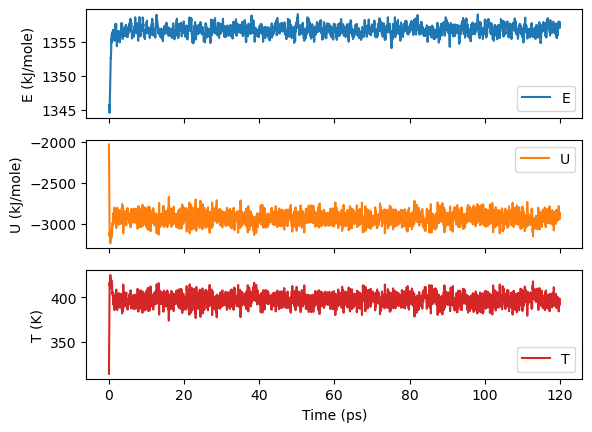

In [31]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Total Energy (kJ/mole)'],label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel('E (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C1',label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel('U (kJ/mole)')

axs[2].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('T (K)')

In [32]:
df['Temperature (K)'][df['Time (ps)'] > 10]

333     407.050073
334     405.954408
335     396.974605
336     388.194249
337     386.770459
           ...    
3995    392.678767
3996    391.326750
3997    391.077468
3998    392.932755
3999    398.044964
Name: Temperature (K), Length: 3667, dtype: float64

In [33]:
subsetT = df['Temperature (K)'][df['Time (ps)'] > 10]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > 10]

In [34]:
from IPython.display import display, Math

Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

<IPython.core.display.Math object>

In [35]:
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

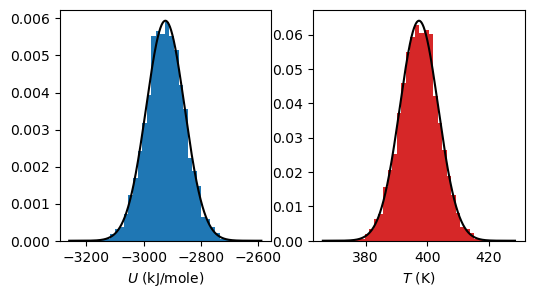

In [36]:
fig, axs = plt.subplots(1, 2,figsize=(6,3))

axs[0].hist(subsetU,bins=30,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=30,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

## Simulação NVT no OpenMM

In [37]:
temperature = 300 * kelvin
integrator = LangevinIntegrator(temperature, 1 / picosecond, 3 * femtoseconds)

In [38]:
# Define um objeto de simulação
simulation = Simulation(topology, system, integrator, platform,)

# Inicializa as posições iniciais
simulation.context.setPositions(initial_positions * L)

# Inicializa velocidades com valores aleatórios à temperatura de 300K.
simulation.context.setVelocitiesToTemperature(temperature)

In [39]:
# Remove reporters existentes, no caso dessa célula ser executada mais de uma vez.
simulation.reporters = []

# Escreve a geometria inicial com um arquivo PDB
positions = simulation.context.getState(getPositions=True).getPositions()
with open("ljinit.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

# Escreve cada frame em arquivo DCD de trajetórias a cada 1000 passos
simulation.reporters.append(DCDReporter("ljtraj.dcd", 1000))

# Escreve num arquivo csv a cada 100 passos 
simulation.reporters.append(
    StateDataReporter(
        "ljscalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True
    )
)

# Escreve na tela a cada 1000 passos 
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True)
)

# Roda a simulação molecular com 40000 passos
simulation.step(40000)

# A próxima linha é necessária para Windows para fechar os arquivos antes de serem abertos
del simulation

#"Step","Temperature (K)"
1000,304.21755316523326
2000,295.95586704867833
3000,303.9331340014472
4000,290.23747579110824
5000,295.26220068058825
6000,303.3545114031593
7000,310.2531612031666
8000,304.12959715856226
9000,312.3726170642783
10000,291.99927819482156
11000,310.73028920793405
12000,302.99842547731316
13000,313.91471265145833
14000,287.7457916621008
15000,306.6274690204971
16000,296.3682567826328
17000,306.9157699697698
18000,303.51982644056585
19000,310.70069684859163
20000,297.55108306791243
21000,298.5749862336838
22000,287.0181685715935
23000,303.3745753289961
24000,307.2345799948869
25000,302.8716226533364
26000,295.45296437855467
27000,308.3760398281754
28000,296.1450048343678
29000,287.19333383955444
30000,304.4970999147383
31000,309.0232307296367
32000,303.7537363162537
33000,299.4806563625165
34000,290.71090262028343
35000,307.9079522364132
36000,292.75748531939234
37000,308.56470087097244
38000,291.3833014397431
39000,293.78145297721926
40000,302.15134767672595


### Análise dos dados 

In [40]:
traj = mdtraj.load("ljtraj.dcd", top="ljinit.pdb")
view = nglview.show_mdtraj(traj)
view.add_unitcell()
view

NGLWidget(max_frame=39)

In [41]:
df = pd.read_csv("ljscalars.csv")

Text(0, 0.5, 'T (K)')

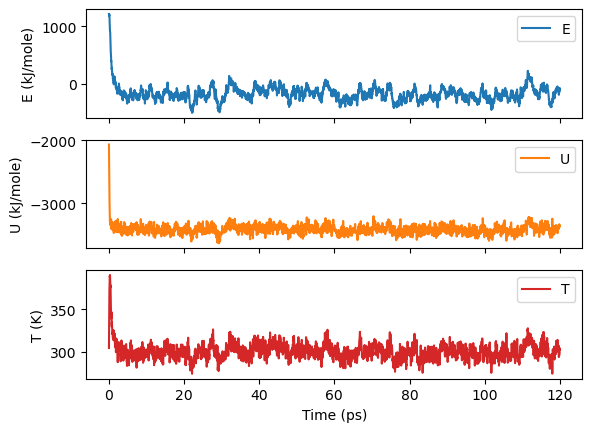

In [42]:
fig, axs = plt.subplots(3, 1, sharex=True)

axs[0].plot(df['Time (ps)'],df['Total Energy (kJ/mole)'],label='E')
axs[0].legend(loc='best')
axs[0].set_ylabel('E (kJ/mole)')

axs[1].plot(df['Time (ps)'],df['Potential Energy (kJ/mole)'],color='C1',label='U')
axs[1].legend(loc='best')
axs[1].set_ylabel('U (kJ/mole)')

axs[2].plot(df['Time (ps)'],df['Temperature (K)'],color='C3',label='T')
axs[2].legend(loc='best')
axs[2].set_xlabel('Time (ps)')
axs[2].set_ylabel('T (K)')

In [43]:
subsetT = df['Temperature (K)'][df['Time (ps)'] > 10]
subsetU = df['Potential Energy (kJ/mole)'][df['Time (ps)'] > 10]

# Energia Potencial
Umean = subsetU.mean()
sigmaU = subsetU.std()

display(Math(rf"U = {Umean:.2f} \pm {sigmaU:.2f}\ kJ/mole"))

# Temperatura
Tmean = subsetT.mean()
sigmaT = subsetT.std()

display(Math(rf"$T = {Tmean:.2f} \pm {sigmaT:.2f}\ K"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

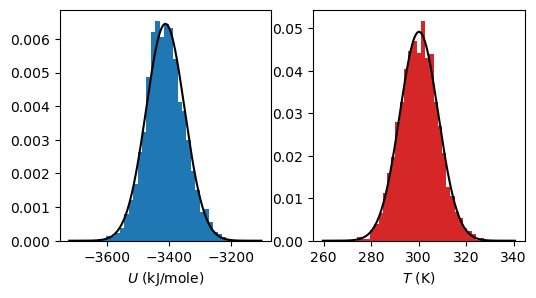

In [47]:
fig, axs = plt.subplots(1, 2,figsize=(6,3))

axs[0].hist(subsetU,bins=30,density=True)
axs[0].set_xlabel(r'$U$ (kJ/mole)')

uarray = Umean+np.arange(-5*sigmaU,5*sigmaU,0.01*sigmaU)
axs[0].plot(uarray,np.sqrt(1/(2*np.pi*sigmaU**2))*np.exp(-0.5*(uarray-Umean)**2/sigmaU**2),color='k')

axs[1].hist(subsetT,bins=30,density=True,color='C3')
axs[1].set_xlabel(r'$T$ (K)')

Tarray = Tmean + np.arange(-5*sigmaT,5*sigmaT,0.01*sigmaT)
axs[1].plot(Tarray,np.sqrt(1/(2*np.pi*sigmaT**2))*np.exp(-0.5*(Tarray-Tmean)**2/sigmaT**2),color='k')

**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> - Baixe a temperatura para $k_B T /\epsilon = 1.0$ e aumente a densidade para $\rho \sigma^3 = 1.2$ 
>